###### <span>Part 1: Exploration <br><a href="https://kimrharper.github.io/port3a.html"> https://kimrharper.github.io/port3a.html</a> </span><br><br><span>Part 2: Analysis <br><a href="https://kimrharper.github.io/port3b.html"> https://kimrharper.github.io/port3b.html</a> </span><br><br><span>Part 3: Models <br><a href="https://kimrharper.github.io/port3c.html"> https://kimrharper.github.io/port3c.html</a> </span>

----

# <span style="color:darkred">Neural Network Assessment of ELL Blog Writing Samples</span>

### <span style="color:darkred">Part 1: </span><span style="color:darkblue">Exploration</span>

__Author:__ Ryan Harper 

----

<a id="top"></a>

<a href='#ov'>Overview</a><br>
<a href='#exp'>Experiment</a><br>
<a href='#sec1'>1. Cleaning Data</a><br>
<a href='#sec2'>2. Exploring the Data</a><br>

<a id="ov"></a>

# <span style="color:darkblue">Overview</span>  <a href='#top'>(top)</a>

__Data Source:__
> http://lang-8.com/ [scraped with Beautiful Soup]

![alt text](../data/language/lang8.png "Title")

__Summary:__
> In my previous profession, I have been teaching English to a diverse range of students of all ages, language background, and country origin. During my professional development, I started to observe that different students with different L1s (1st Language) tended to display different patterns of communication that appeared to have some connection to either education in their country of origin or a connection to the linguistic structure of their first language. Different ELL (English Language Learners) needed to focus on different aspects of the English language depending on their background. The purpose of this project is to use a large number of blog posts from a language practicing website and explore whether or not the L1 has any significant impact on the blog writing style of the English learner.<br><br>Part 1: Explore the data to find any noteworthy trends in linguistic structure: <ol><li> vocabulary (word freq, collocations, and cognates) <li>syntax (sentence structure)<li>grammar (i.e. grammar complexity of sentences) <li>errors (types of errors) <li> parts of speech (NLTK Abbreviations: https://pythonprogramming.net/natural-language-toolkit-nltk-part-speech-tagging/)<li>Word Frequency (ANC: http://www.anc.org/data/anc-second-release/frequency-data/)</ol><br>Part 2: Use linguistic trends to determine whether or not a learner's first language can be predicted.

__Variables:__
>__id:__ _User ID_<br>
__time:__ _Time the blog post was scraped (in order of user posted time)_ <br>
__title:__ _Title of the blog post_<br>
__content:__ _The blog post_<br>
__language:__ _User's self-reported first language_

<a id="exp"></a>

# <span style="color:darkblue">Experiment</span> <a href='#top'>(top)</a>

__Hypothesis:__ 
> L1 (first language) experience and academic environment influences ELLs' (English Language Learners') writing style. The L1 of ELLs can be predicted by looking at English blog posts and identifying patterns unique to their L1.

__Observations:__
><li> Chinese learners use more reflexive pronouns than Japanese learners  <li>Japanese and Chinese learners appear to favor different prepositions<li>Japanese and Chinese learners have a different range of subjectivity scores (from Textblob)<li>K Nearest Neighbors does not appear to work for this NLP project<li>Naive Bayes and Random Forest outperformed other models<li>Logistic Regression occasionally has strong predictions (but the order of the first few ranked features do not appear significant)

__Method:__
> Using multiple models, the aim of this project is to explore how different models can handle the data (target and features) and to see what information can be gained from using multiple different models. Ultimately, the goal is to determine which models are appropriate for a binary (discrete) target with features that are both qualitative (discrete) and quantitative (ranked/continuous).

<a id="sec1"></a>

# <span style="color:darkblue">1. Cleaning the Data</span>  <a href='#top'>(top)</a>

In [1]:
# from nltk.corpus import brown
# nltk.download('brown')

In [2]:
# iPython/Jupyter Notebook
import time
from pprint import pprint
import warnings
from IPython.display import Image

# Data processing
import scipy
import pandas as pd
import plotly as plo
import numpy as np
import seaborn as sns
from collections import Counter
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# NLP
import textblob
from nltk.corpus import stopwords as sw
from nltk.util import ngrams
from nltk.corpus import brown
import nltk
import re
from nltk.tokenize import RegexpTokenizer
import difflib
from string import punctuation

# import altair as alt

In [3]:
# load and close files
def get_text(link):
    with open(link) as f:
        output = f.read()
    return output

In [4]:
# Jupyter Settings and Imports
%pylab
%matplotlib inline 
warnings.filterwarnings(action='once')

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [5]:
# Import data
blog = pd.read_csv('../data/language/blogdata-reduced.csv')
blog.info()

# POS Table for reference
poscv = pd.read_csv('../data/pos.csv')
poscv = poscv.iloc[0:17]
poscv.columns = ['Set1','Set 2']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18702 entries, 0 to 18701
Data columns (total 6 columns):
Unnamed: 0    18702 non-null int64
id            18702 non-null int64
time          18702 non-null object
title         18702 non-null object
content       18702 non-null object
language      18702 non-null object
dtypes: int64(2), object(4)
memory usage: 876.7+ KB


In [6]:
# Import data
blog = pd.read_csv('../data/language/blogdata-reduced.csv')

In [10]:
def assess_language():
    vals = list(blog.language.value_counts().values)
    languages = list(blog.language.value_counts().index)
    plt.figure(figsize(6,4))
    plt.bar(languages,vals,edgecolor='black')
    plt.title('Blogs by L1 Count')
    plt.xticks(rotation='vertical')
    plt.show()

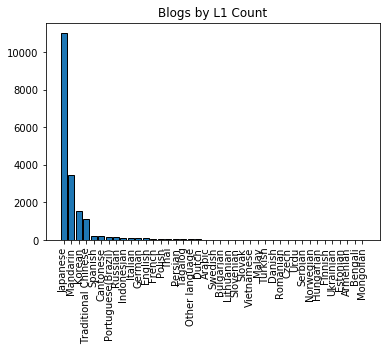

In [11]:
assess_language()

In [12]:
# Clean Data
del blog['Unnamed: 0']
blog.language = blog.language.mask(blog.language == 'Mandarin', 'Traditional Chinese').replace(['Persian', 'Arabic',
        'Bulgarian', 'Swedish', 'Slovenian', 'Slovak', 'Malay', 'Turkish','Romanian', 'Czech', 'Danish', 'Vietnamese',
        'Norwegian','Serbian','Other language','Lithuanian', 'Ukrainian', 'Finnish','Estonian','Bengali','Russian', 
        'Spanish','French', 'German', 'Cantonese','Mongolian', 'Tagalog', 'Polish', 'Dutch','Italian', 'Portuguese(Brazil)', 
        'Thai', 'Indonesian', 'Cantonese','Urdu', 'Hungarian','Korean','English'], np.nan)
blog = blog.dropna().sample(frac=1)

del blog['title']
del blog['time']

In [13]:
blog.info(verbose=False, memory_usage=False,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15581 entries, 9683 to 9910
Columns: 3 entries, id to language
dtypes: int64(1), object(2)

In [14]:
# Confirmation that there are no more null values
blog.isnull().values.any()

False

In [15]:
def lettercheck(val):
    reLetters = re.compile('[^a-zA-Z]')
    onlyletters = reLetters.sub('', val)
    return len(onlyletters)/len(val)

In [16]:
blog['letters_per'] = blog.content.apply(lettercheck)
print('Removing Blogs with less than 70% letter percentage: {}'.format(blog.loc[blog['letters_per'] <= .7].content.count()))
blog = blog.loc[blog['letters_per'] > .7]

Removing Blogs with less than 70% letter percentage: 1362


In [17]:
blog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14219 entries, 9683 to 9910
Data columns (total 4 columns):
id             14219 non-null int64
content        14219 non-null object
language       14219 non-null object
letters_per    14219 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 555.4+ KB


<a id="sec2"></a>

# <span style="color:darkblue">2. Exploring the Data</span>  <a href='#top'>(top)</a>

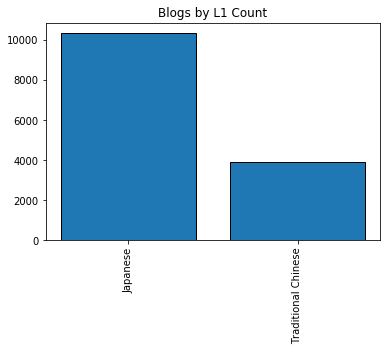

In [18]:
assess_language()

In [13]:
print("Posts by 'Native' English Speakers: {}".format(blog.id.loc[blog.language == 'English'].count()))

Posts by 'Native' English Speakers: 0


<a id="nlp"></a>

### <span style="color:darkred">NLP: Spell Check, Tokenization, Collocations, Parts of Speech, and Syntax</span>  <a href='#top'>(top)</a>

__Word Level Ranking__

In [14]:
ANCI_WORDS = pd.read_csv('../data/language/ANC-written-count.txt', 
                         sep='\t', 
                         encoding='latin-1', 
                         names=['word','stem','pos','freq'],header=None)
word_freq = list(zip(ANCI_WORDS['word'].values,ANCI_WORDS['freq'].values))

full_words_dict = {}
words_dict = {}

# full_freq
i = 0
for w in word_freq:
    i = i + 1
    if w[0] not in full_words_dict:
        full_words_dict[w[0]] = w[1]
        
# basic_freq
i = 0
for w in word_freq:
    i = i + 1
    if w[0] not in words_dict:
        if i < 500:
            words_dict[w[0]] = 1
        elif (i >= 500) & (i < 5000):
            words_dict[w[0]] = 2
        elif (i >= 5000) & (i < 10000):
            words_dict[w[0]] = 3
        elif (i >= 5000) & (i < 20000):
            words_dict[w[0]] = 4

In [15]:
def full_freq_rating(l):
    score = 0
    c=0
    for w in l:
        if w in full_words_dict:
            c = c + 1
            score = score + full_words_dict[w]
    if c == 0:
        c=1
    return score / c

def freq_rating(l):
    score = 0
    c=0
    for w in l:
        if w in words_dict:
            c = c + 1
            score = score + words_dict[w]
    if c == 0:
        c=1
    return score / c

__TextBlob__

In [16]:
%%time
blob = blog.content.apply(lambda val: textblob.TextBlob(val))

CPU times: user 246 ms, sys: 16.1 ms, total: 262 ms
Wall time: 264 ms


In [17]:
def posbigram(val):
    bigramlist,l = [],[]
    
    for s in val.sentences:
        ns = textblob.TextBlob(str(s)).tags
        l = [v[1] for v in ns]
        bigrm = list(nltk.bigrams(l))
        
        for bigram in bigrm:
            bigramlist.append('-'.join(bigram))
        
    return bigramlist

def postrigram(val):
    trigramlist, l = [],[]
    
    for s in val.sentences:
        ns = textblob.TextBlob(str(s)).tags
        l = [v[1] for v in ns]
        trigrm = list(nltk.trigrams(l))
        
        for trigram in trigrm:
            trigramlist.append('-'.join(trigram))
        
    return trigramlist

In [18]:
def per_check(string_value, total):
    percentage = len(string_value)
    if percentage != 0:
        percentage = float(total / percentage) * 100
    else:
        percentage = 0
    return percentage

def punc_count(string_value):
    count = 0
    for c in string_value:
        if c in punctuation:
            count+= 1
    return per_check(string_value, count)

def caplet_count(string_value):
    count = 0
    for c in string_value:
        if c.isupper():
            count+= 1
    return per_check(string_value, count)      

__General Text Analysis__

In [19]:
%%time
blog['wc'] = blob.apply(lambda val: len(val.words))
blog['sc'] = blob.apply(lambda val: len(val.sentences))
blog['tokens'] = blob.apply(lambda val: [w.lower() for w in val.words])
blog['sent_pol'] = blob.apply(lambda val: val.sentiment[0])
blog['sent_subj'] = blob.apply(lambda val: val.sentiment[1])
blog['cap_let'] = blob.apply(caplet_count)
blog['punc_count'] = blob.apply(punc_count)

CPU times: user 43 s, sys: 694 ms, total: 43.7 s
Wall time: 44.1 s


In [20]:
blog['freq_score'] = blob.apply(lambda val: freq_rating(val.words))
blog['full_freq_score'] = blob.apply(lambda val: full_freq_rating(val.words))

__Data Cleaning Round 2__

In [21]:
blog = blog[blog['wc'] >= 4]
blog = blog[blog['full_freq_score'] > 1500]

__Parts of Speech Tokens__

In [22]:
%%time
blog['pos'] = blob.apply(lambda val: [v[1] for v in val.tags])
blog['pos2'] = blob.apply(posbigram)
blog['pos3'] = blob.apply(postrigram)

/anaconda3/lib/python3.6/site-packages/nltk/util.py:491: DeprecationWarning:

generator 'ngrams' raised StopIteration



CPU times: user 5min, sys: 7.53 s, total: 5min 8s
Wall time: 5min 12s


__Backup File__

__Frequent Words Per Language__

In [23]:
%%time
js = Counter(reduce((lambda x, y: x + y), blog.content[blog.language == 'Japanese'].str.lower().apply(nltk.word_tokenize))).most_common(1000)
cs = Counter(reduce((lambda x, y: x + y), blog.content[blog.language == 'Traditional Chinese'].str.lower().apply(nltk.word_tokenize))).most_common(1000)
cl,jl = [l[0] for l in cs],[l[0] for l in js]
cuw,juw = [item for item in cl if item not in jl],[item for item in jl if item not in cl]

CPU times: user 1min 4s, sys: 17.1 s, total: 1min 21s
Wall time: 1min 23s


<a id="feature"></a>

# <span style="color:darkblue">2. Feature Processing:</span>  <a href='#top'>(top)</a>

In [24]:
def create_dummy_binary_df(df,col,name,keep=[],):
    colset = set(df[col].sum())
    finalsetlist = []
    if len(keep) > 0:
        colset = [k for k in keep if k in colset]
    
    for c in colset:
        colname = name+'_'+str(c)
        df[colname] = df[col].apply(lambda val: val.count(c))
        
        if df[colname].sum() < 1:
            del df[colname]
        else:
            finalsetlist.append(colname)
        
    print('Created dummy counter for {} features'.format(name))
        
    return finalsetlist

In [25]:
def create_dummy_count_df(df,col,colset,name,keep=[]): 
    finalsetlist = []
    if len(keep) > 0:
        colset = [k for k in keep if k in colset]
    
    for c in colset:
        colname = name+'_'+str(c)
        df[colname] = df[col].apply(lambda val: val.count(c))
        
        if df[colname].sum() < 1:
            del df[colname]
        else:
            finalsetlist.append(colname)
        
    print('Created dummy counter for {} features'.format(name))
        
    return finalsetlist

In [26]:
%%time
colset = set(blog['tokens'].sum())

CPU times: user 1min 30s, sys: 25.8 s, total: 1min 56s
Wall time: 1min 59s


In [27]:
%%time
prplist = list(ANCI_WORDS['word'][ANCI_WORDS.pos == 'PRP'])
pronouns = create_dummy_count_df(blog,'tokens',colset,'prp',prplist)

cclist = list(ANCI_WORDS['word'][ANCI_WORDS.pos == 'CC'])
coordinators = create_dummy_count_df(blog,'tokens',colset,'cc',cclist)

inlist = list(ANCI_WORDS['word'][ANCI_WORDS.pos == 'IN'])
preposition = create_dummy_count_df(blog,'tokens',colset,'prep',inlist)

adverblist = list(ANCI_WORDS['word'][ANCI_WORDS.pos == 'RB'])[0:50]
adverb = create_dummy_count_df(blog,'tokens',colset,'adv',adverblist)

punct = create_dummy_count_df(blog,'tokens',colset,'punct',list(punctuation))

cuw = create_dummy_count_df(blog,'tokens',colset,'cuw',cuw)
juw = create_dummy_count_df(blog,'tokens',colset,'juw',juw)

Created dummy counter for prp features
Created dummy counter for cc features
Created dummy counter for prep features
Created dummy counter for adv features
Created dummy counter for punct features
Created dummy counter for cuw features
Created dummy counter for juw features
CPU times: user 12.6 s, sys: 191 ms, total: 12.8 s
Wall time: 12.7 s


In [28]:
%%time
pos1set = set(blog['pos'].sum())
pos2set = set(blog['pos2'].sum())
pos3set = set(blog['pos3'].sum())

CPU times: user 3min 33s, sys: 1min, total: 4min 33s
Wall time: 4min 32s


In [29]:
%%time
pos2 = create_dummy_count_df(blog,'pos2',pos2set,'pos2')
pos1 = create_dummy_count_df(blog,'pos',pos1set,'pos1')

Created dummy counter for pos2 features
Created dummy counter for pos1 features
CPU times: user 30.5 s, sys: 1.39 s, total: 31.9 s
Wall time: 31.5 s


In [30]:
%%time
pos3 = create_dummy_count_df(blog,'pos3',pos3set,'pos3')

Created dummy counter for pos3 features
CPU times: user 7min 54s, sys: 1min 46s, total: 9min 41s
Wall time: 9min 10s


In [31]:
letters1 = []
for let in 'abcdefghijklmnopqrstuvwxyz':
    name = 'let1_'+let
    blog[name] = blog.tokens.apply(lambda val: ''.join(val).count(let))
    letters1.append(name)

In [32]:
%%time
alphabet = list('abcdefghijklmnopqrstuvwxyz')
letters2 = []
for let in alphabet:
    for let2 in alphabet:
        letters2.append(let+let2)

letters2name = []        
for let in letters2:
    name = 'let2_'+let
    blog[name] = blog.tokens.apply(lambda val: ' '.join(val).count(let))
    if blog[name].sum() < 10:
        del blog[name]
    else:
        letters2name.append(name)        
letters2 = letters2name

CPU times: user 43.9 s, sys: 10.4 s, total: 54.2 s
Wall time: 51.9 s


In [33]:
%%time
# For backup
blog.to_csv('blogfeatures.csv')

CPU times: user 3min 39s, sys: 9.12 s, total: 3min 48s
Wall time: 1h 14min 39s


In [34]:
# For second notebook
%store blog

Stored 'blog' (DataFrame)


<a id="sec3"></a>